In [3]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import gsw
import os
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from salishsea_tools import viz_tools
from scipy.optimize import curve_fit
from datetime import datetime, timedelta
from matplotlib import animation
from IPython.display import HTML

%matplotlib inline

In [4]:
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)

### Build idealized basin, islands, and channels

In [84]:
# Build coordinates
j, i = bathy.Bathymetry.shape
x = np.arange(i)
y = np.arange(j)
x, y = np.meshgrid(x, y, indexing='xy')

# Make main basin
z = -1 * (np.cosh((x - 200)/12)*20 + np.cosh((y - 550)/35)) + 400

# Add end channels
for y_0 in [168, 932]:
    z = z + 4000 * np.exp(-((x - 200)/10)**2 - ((y - y_0)/94)**2)

# Add roughness
for y_0 in range(310, 791, 15):
    for x_0 in [170, 230]:
        z = z - 190 * np.exp(-((x - x_0)/10)**2 - ((y - y_0)/5)**2)

# Add cape
#z = z - 1000 * np.exp(-((x - 142)/15)**2 - ((y - 550)/5)**2)
#z = z - 1000 * np.exp(-((x - 143)/20)**2 - ((y - 550)/5)**2)
z = z - 1000 * np.exp(-((x - 150)/25)**2 - ((y - 550)/5)**2)

# Trim negative points as land
z[z < 0] = 0

### Visualize

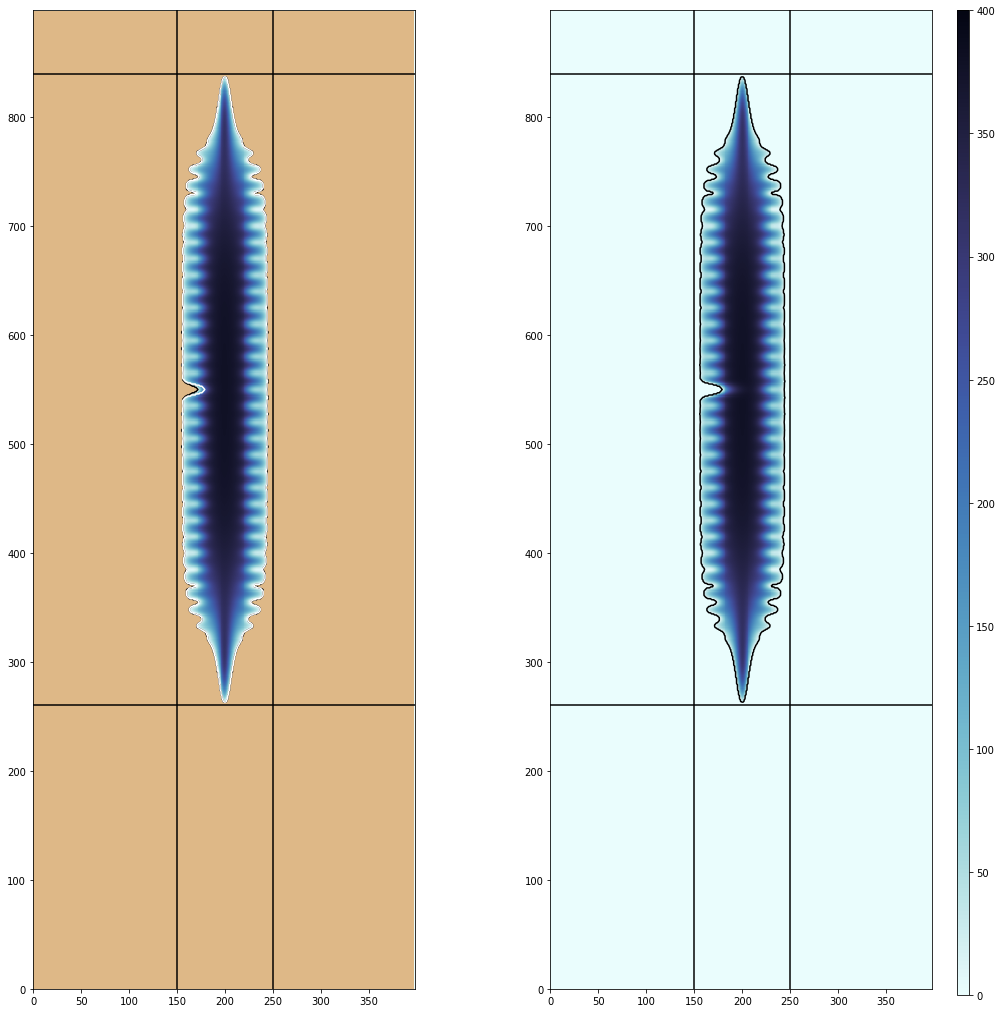

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(17, 18))
for ax in axs:
    ax.set_xlim([0, 398])
    ax.set_ylim([0, 898])
    viz_tools.set_aspect(ax)

c = axs[0].pcolormesh(bathy.Bathymetry, cmap=cmocean.cm.ice_r, vmin=0, vmax=400)
axs[0].contourf(bathy.Bathymetry, levels=[-0.01, 0.01], colors='burlywood')
axs[0].contour(bathy.Bathymetry, levels=[-0.01, 0.01], colors='k')
axs[0].contour(z, levels=1, colors='w')

axs[1].pcolormesh(z, cmap=cmocean.cm.ice_r, vmin=0, vmax=400)
axs[1].contour(z, levels=1, colors='k')

for ax in axs:
    ax.plot([0, 398], [260, 260], 'k-')
    ax.plot([0, 398], [840, 840], 'k-')
    ax.plot([150, 150], [0, 898], 'k-')
    ax.plot([250, 250], [0, 898], 'k-')

cax = fig.add_axes([0.9, 0.12, 0.01, 0.76])
fig.colorbar(c, cax=cax)
plt.show()

### Save new pond bathy to netCDF

In [86]:
# Define subdomain lims
xrange = [150, 250]
yrange = [260, 840]

# Update bathy field and grid and save to netCDF
bathy.update({'Bathymetry': (['y', 'x'], z)}).isel(y=slice(*yrange), x=slice(*xrange)).to_netcdf('/data/bmoorema/MEOPAR/grid/idealized/bathymetry_pond_cape3.nc')
#grid.isel(y=slice(*yrange), x=slice(*xrange)).to_netcdf('/data/bmoorema/MEOPAR/grid/idealized/coordinates_pond_basic.nc')

### Initial stratification
Define fit functions

In [331]:
def expfit(z, a, b, c, d):
    """Simple exponential fit functions
    """
    
    return a * np.exp(-b * z) + c * z + d

In [4]:
def rho_from_N2(z, a, b, c, d):
    """Rho integrated from N2 exponential fit
    -rho_0 / g * result + rho(z=0)
    """
    
    return a / b * (1 - np.exp(-b * z)) + c / 2 * z**2 + d * z

Spatially average T and S climatologies, calc $\rho$ and N$^2$, fit N$^2$ and CT to exponentials and calc $\rho$ and SA

In [7]:
deptht_shallow = xr.open_dataset('/data/bmoorema/results/SalishSeaPond_basic_S4d/SalishSeaIdeal_1d_20170701_20170706_grid_T.nc').deptht.values

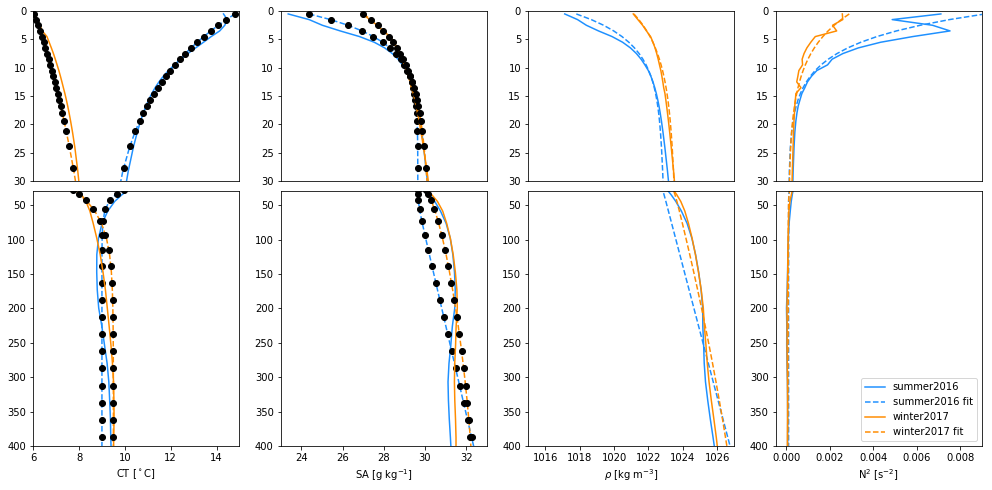

In [8]:
xrange = [150, 250]
yrange = [315, 785]

# Physical parameters
g = -9.81
rho_0 = 1030

# Initialize raw averages dict
raw = {'summer2016': {}, 'winter2017': {}}

# Initialize fits dict with fit params and labels
fits = {
    'summer2016': {
        'params': {
            'CT': (6, 1/15, 0, 9),
            'N2': (0.01, 1/5, 0, 1e-4),
            'rho_surf': 1017.3,
        },
    },
    'winter2017': {
        'params': {
            'CT': (-3.5, 1/40, 0, 9.5),
            'N2': (0.003, 1/7, -1e-7, 1e-4),
            'rho_surf': 1021.0,
        },
    },
    'labels': {
        'CT': 'CT [$^\circ$C]',
        'SA': 'SA [g kg$^{-1}$]',
        'rho': '$\\rho$ [kg m$^{-3}$]',
        'N2': 'N$^2$ [s$^{-2}$]',
    },
}

TRC_ini = xr.open_dataset(
    '/data/bmoorema/MEOPAR/tracers/initial/Bathy201702_initial.nc',
).isel(time_counter=0, x=slice(*xrange), y=slice(*yrange)).drop([
    'TRNDON', 'TRNMICZ', 'TRNMYRI', 'TRNNH4', 'TRNNO3',
    'TRNTRA', 'TRNPHY', 'TRNDIAT', 'TRNPON', 'TRNSi', 'TRNbSi',
])
TRC_ini.attrs['source'] = 'http://bitbucket.org/salishsea/analysis-ben/raw/tip/notebooks/NEMOConfigSetup.ipynb'
TRC_ini.attrs['comment'] = 'All physical tracers'

# Make figure grid
fig, axs = plt.subplots(2, 4, figsize=(17, 8), gridspec_kw={'height_ratios': [2, 3], 'hspace': 0.05})

# Loop through seasons
for season, color in zip(['summer2016', 'winter2017'], ['dodgerblue', 'darkorange']):
    
    # Extract CT and SA
    filename = f'/data/bmoorema/MEOPAR/tracers/initial/{season}_201702.nc'
    data = xr.open_dataset(filename).isel(x=slice(*xrange), y=slice(*yrange))
    z = data.deptht
    raw[season]['SA'] = np.ma.masked_values(data.vosaline, 0).mean(axis=(1, 2)).data
    raw[season]['CT'] = np.ma.masked_values(data.votemper, 0).mean(axis=(1, 2)).data
    
    # Calc rho and N2
    raw[season]['rho'] = gsw.rho(raw[season]['SA'], raw[season]['CT'], z)
    raw[season]['N2'] = -g / rho_0 * np.diff(raw[season]['rho']) / np.diff(z)
    N2_deep = raw[season]['N2'][-2]
    raw[season]['N2'] = np.append(raw[season]['N2'][:-1], [N2_deep, N2_deep])
    
    # Fit N2 and CT to exponentials, calc rho and SA
    fits[season]['N2'] = expfit(z, *fits[season]['params']['N2'])
    fits[season]['CT'] = expfit(z, *fits[season]['params']['CT'])
    fits[season]['rho'] = -rho_0 / g * rho_from_N2(z, *fits[season]['params']['N2']) + fits[season]['params']['rho_surf']
    fits[season]['SA'] = gsw.SA_from_rho(fits[season]['rho'], fits[season]['CT'], z)
    
    T = xr.Dataset({
        'tn': (['deptht'], fits[season]['CT'].values),
        'sn': (['deptht'], fits[season]['SA'])
    },
    coords={
        'deptht': (fits[season]['CT'].deptht.values),
    }).interp(deptht=deptht_shallow)
    CT = T.tn.values
    CT[0] = fits[season]['CT'].values[0]
    SA = T.sn.values
    SA[0] = fits[season]['SA'][0]
    
    #CT[0:19] = 15
    #CT[19:] = 9
    #SA[0:19] = 25
    #SA[19:] = 31
    
    # Plot curves
    for row, ylim in zip(axs, ([30, 0], [400, 30])):
        for ax, key, xlim in zip(row, ['CT', 'SA', 'rho', 'N2'], ([6, 15], [23, 33], [1015, 1027], [-0.0005, 0.009])):
            ax.plot(raw[season][key], z, label=season, color=color)
            ax.plot(fits[season][key], z, '--', label=f'{season} fit', color=color)
            if key is 'CT':
                ax.plot(CT, T.deptht, 'ko')
            elif key is 'SA':
                ax.plot(SA, T.deptht, 'ko')
            ax.set_ylim(ylim)
            ax.set_xlim(xlim)
            if ylim[1] == 0:
                ax.xaxis.set_ticks([])
            else:
                ax.set_xlabel(fits['labels'][key])

    # Export new initialization fields to file
    TRC_ini.attrs['title'] = f'Initialization tracers for idealized pond bathymetry from {season}'
    TRC_ini.attrs['references'] = 'tracers/initial/idealized/initial_strat/' + f'{season}_pond.nc'
    TRC_ini.attrs['history'] = '[{}] Created netCDF4 zlib=True dataset.'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    TRC_ini.update({
        'tn': (
            ['deptht', 'y', 'x'],
            np.ones(data.votemper.shape) * CT[:, np.newaxis, np.newaxis],
        ),
        'sn': (
            ['deptht', 'y', 'x'],
            np.ones(data.votemper.shape) * SA[:, np.newaxis, np.newaxis],
        ),
    }).to_netcdf(f'/data/bmoorema/MEOPAR/tracers/initial/idealized/{season}_pond.nc')
        
axs[1, 3].legend(loc=4)
plt.show()

## Compare configurations

In [32]:
def calc_sigma_surface(rho_0):
    """Calculate rho_0 surface depth
    """
    
    index = abs(rho - rho_0).argmin(axis=0)
    _, m, n = rho.shape
    depth_rho = np.zeros((m, n))
    for j in range(m):
        for i in range(n):
            depth_rho[j, i] = deptht[index[j, i]]
                
    return depth_rho

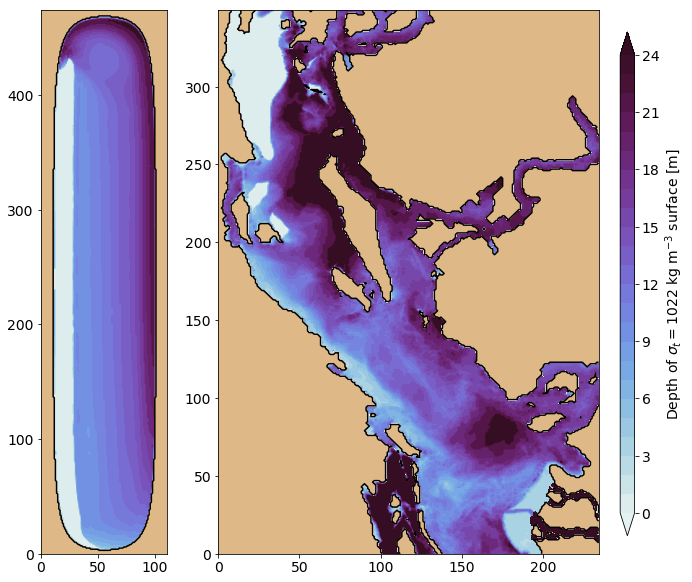

In [102]:
# Define paths and strings
results_paths = [
    '/data/bmoorema/results/SalishSeaPond_old/SalishSeaPond_basic_summer_S24H',
    '/results/SalishSea/hindcast_v1/27apr15',
]
file_strs = ['Lake_1h_20170701_20170704', '_1h_20150427_20150427']
mask_paths = [
    os.path.join(results_paths[0], 'mesh_mask.nc'),
    '/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc',
]
xlims = [
    [18, 130],
    [115, 350],
]
ylims = [
    [0, 475],
    [400, 750],
]
ts = [30, 0]

# Make figure
fig, axs = plt.subplots(1, 2, figsize=(10, 10), gridspec_kw={'width_ratios': [1, 3]})
cax = fig.add_axes([0.93, 0.15, 0.02, 0.7])

# Loop through results
for ax, t, results_path, file_str, mask_path, xlim, ylim in zip(axs, ts, results_paths, file_strs, mask_paths, xlims, ylims):

    T = xr.open_dataset(
        os.path.join(results_path, f'SalishSea{file_str}_grid_T.nc'),
    ).isel(time_counter=t, x=slice(*xlim), y=slice(*ylim))
    tmask = xr.open_dataset(mask_path).isel(t=0, z=0, x=slice(*xlim), y=slice(*ylim)).tmask
    deptht = T_pond.deptht.values
    rho = gsw.rho(T.vosaline, T.votemper, deptht[:, np.newaxis, np.newaxis])
    depth_1022 = calc_sigma_surface(1022)

    c = ax.contourf(np.ma.masked_where(tmask == 0, depth_1022), levels=range(25), cmap=cmocean.cm.dense, extend='both')
    ax.contourf(tmask, levels=[-0.01, 0.01], colors='Burlywood')
    ax.contour(tmask, levels=[-0.01, 0.01], colors='k')
    
fig.colorbar(c, cax=cax, label='Depth of $\sigma_t=1022$ kg m$^{-3}$ surface [m]')

fig.savefig('/home/bmoorema/Desktop/density_comparisons.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [377]:
from dateutil.parser import parse
from salishsea_tools import utilities

In [347]:
def expfit(z, a, b, c, d):
    """Simple exponential fit functions
    """
    
    return a * np.exp(-b * z) + c * z + d

In [384]:
path = '/results2/SalishSea/nowcast-green.201806'
daterange = [parse(date) for date in ['2016 Jun 1', '2016 Jul 1']]
datelist = [daterange[0] + timedelta(days=day) for day in range(np.diff(daterange)[0].days)]
CT, SA = np.empty([0, 40]), np.empty([0, 40])

In [385]:
bar = utilities.statusbar('loading...')
for date in bar(datelist):
    datestr = date.strftime('%Y%m%d')
    T = xr.open_dataset(os.path.join(
        path, date.strftime('%d%b%y').lower(),
        f'SalishSea_1h_{datestr}_{datestr}_grid_T.nc',
    )).isel(y=655, x=160)
    CT = np.concatenate([CT, T.votemper.mean(dim='time_counter').values[np.newaxis, :]])
    SA = np.concatenate([SA, T.vosaline.mean(dim='time_counter').values[np.newaxis, :]])
    
CT = CT.mean(axis=0)
SA = SA.mean(axis=0)

loading... 100% (30 of 30) |###############################################|Time: 0:11:38


In [461]:
# Profiles
profiles = {
    'raw': {
        'CT': CT,
        'SA': SA,
    },
    'fit': {
        'CT': expfit(T.deptht, 7, 0.1, 0, 10),
        'SA': expfit(T.deptht, ),
    }
}
for profile in profiles.items():
    profile[1]['rho'] = gsw.rho(profile[1]['SA'], profile[1]['CT'], T.deptht.values) - 1000

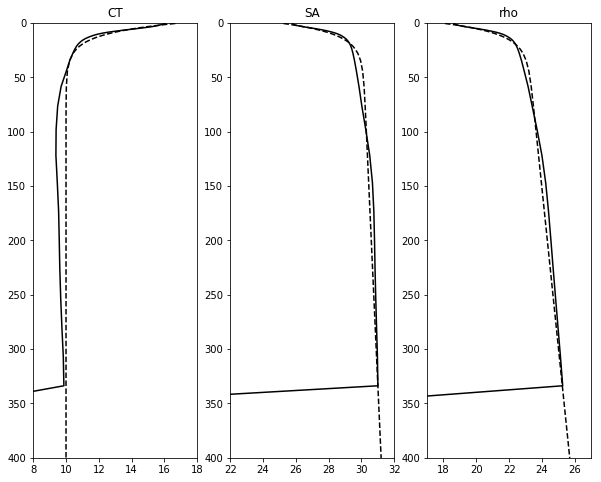

In [462]:
fig, axs = plt.subplots(1, 3, figsize=(10, 8))
for ax, key, xlim in zip(axs, ['CT', 'SA', 'rho'], [[8, 18], [22, 32], [17, 27]]):
    for profile, linestyle in zip(profiles.items(), ['-', '--']):
        ax.plot(profile[1][key], T.deptht, 'k-', linestyle=linestyle)
        ax.set_xlim(xlim)
        ax.set_ylim([400, 0])
        ax.set_title(key)

In [315]:
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')

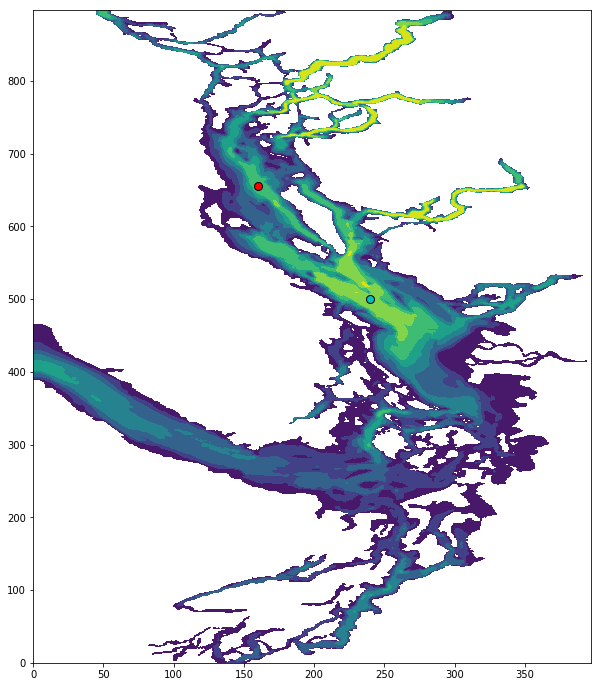

In [328]:
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
ax.contourf(bathy.Bathymetry)
ax.plot(160, 655, 'ko', markerfacecolor='r', markersize=8)
ax.plot(240, 500, 'ko', markerfacecolor='c', markersize=8)